In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [4]:
data_path = '/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/'

cntFile = data_path + 'S004-2_Alice.cnt' #'20220811_test.cnt'
'''
S001_Alice.cnt: 最外圈的（編號尾數7的）沒有很毛，所以不exclude
'''

raw = mne.io.read_raw_cnt(cntFile)
raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])

Reading 0 ... 808679  =      0.000 ...   808.679 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2022-11-04 09:15:10 UTC
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEOG', 'VEOG']


In [30]:
# List out the triggers
events = mne.events_from_annotations(raw)
#print(events)
print(events[1])
#event = events[0]  #時間要除以1000=事件發生的時間點
#print("The Code = ", events[1])

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', '99']
{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 111 samples (0.444 sec)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


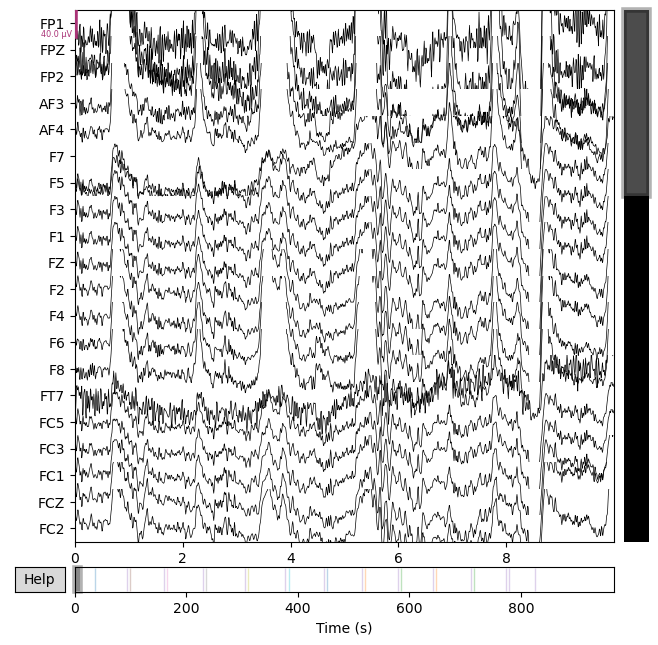

Channels marked as bad: none


In [20]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq = 250)
n_raw.filter(0, 30, phase= 'zero-double')
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg = True, stim = True, exclude = ['M1', 'M2', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEOG', 'VEOG'])

n_raw.plot()


#reject = dict(mag=1.5e-12)  #1.5 pT
#tmin = -0.1         # pre stimulis interval (in seconds) #
#tmax = 0.7          # post stimulus interval #

#event_id = {{'1': 1, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12,'10': 2, '11': 3, '12': 4, '99': 13}}

In [21]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

ica_.plot_sources(n_raw)
ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_raw)#, exclude=[0, 1, 3, 4, 12])

Fitting ICA to data using 57 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.2s.
Creating RawArray with float64 data, n_channels=15, n_times=241620
    Range : 0 ... 241619 =      0.000 ...   966.476 secs
Ready.


[<MNEFigure size 975x731.5 with 15 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 57 PCA components


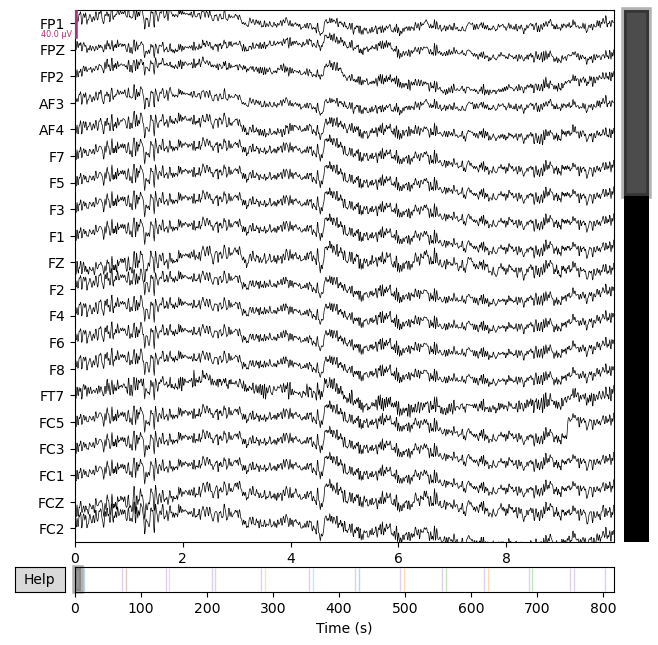

Channels marked as bad: none


In [18]:
# What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Exclude certain components
"""
S001:[0]  # REDO this
S002:[0, 1, 3, 8, 10]
"""
ica_.exclude = [0, 1, 3, 8, 10]
raw_clean = n_raw.copy()
ica_.apply(raw_clean)
raw_clean.plot()

In [116]:
# Cutting the data based on the trigger of that 
'''
print(events[0])
print(type(events[0]))
print(events[1])
print(type(events[1]))
'''
#print(events[0][0][0])
#print(events[0][0][2])
print(len(events[0]))

timeArrays = events[0]


timeLIST = []
for i in timeArrays:
    timePoints = i[0]
    markers = i[2]
    timeLIST.append(timePoints)
#print(timeLIST)
#print(timeLIST[0])

tmpLIST = []
n_timeLIST = []
for k in range(24):
    tmin = float(timeLIST[k])/1000
    tmax = float(timeLIST[k+1])/1000
    cut_file = raw.copy().crop(tmin = tmin, tmax= tmax)
    cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
print("ALL DONE!")

24
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif
[done]


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif
[done]


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif
[done]


IndexError: list index out of range